<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m3_mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

from google.colab import files

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

Cloning into 'AE-w.-Bottleneck-Residual-Blocks'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 270 (delta 45), reused 21 (delta 4), pack-reused 168
Receiving objects: 100% (270/270), 9.67 MiB | 7.95 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32
input_size = (img_ht,img_wd,3)

batch_size = 128

### **Loading the dataset**

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteV3SWZT/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteV3SWZT/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# **Latent dim 320**

In [5]:
K.clear_session()

latent_dim = 320

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

### **The model**



In [6]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_1 (Dense)             (None, 640)               205440    
                                                                 
 re_lu_25 (ReLU)             (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 1280)              820480    
                                                                 
 re_lu_26 (ReLU)             (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              5246976   
                                                                 
 re_lu_27 (ReLU)             (None, 4096)              0   

In [8]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 320)               17197056  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         23272835  
                                                                 
Total params: 40469891 (154.38 MB)
Trainable params: 40445699 (154.29 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


### **Training**


In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mae', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=100, callbacks=[callback])

Epoch 1/100
391/391 [==============================] - 77s 94ms/step - loss: 0.1440 - accuracy: 0.4700 - val_loss: 0.1320 - val_accuracy: 0.4834
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 0.1116 - accuracy: 0.5397 - val_loss: 0.1245 - val_accuracy: 0.5634
Epoch 3/100
391/391 [==============================] - 29s 73ms/step - loss: 0.1010 - accuracy: 0.5902 - val_loss: 0.1124 - val_accuracy: 0.5403
Epoch 4/100
391/391 [==============================] - 29s 73ms/step - loss: 0.0957 - accuracy: 0.6072 - val_loss: 0.1004 - val_accuracy: 0.6092
Epoch 5/100
391/391 [==============================] - 29s 73ms/step - loss: 0.0926 - accuracy: 0.6161 - val_loss: 0.0997 - val_accuracy: 0.5767
Epoch 6/100
391/391 [==============================] - 29s 73ms/step - loss: 0.0898 - accuracy: 0.6223 - val_loss: 0.0937 - val_accuracy: 0.6196
Epoch 7/100
391/391 [==============================] - 29s 73ms/step - loss: 0.0877 - accuracy: 0.6296 - val_loss: 0.0962 - val_ac

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss='mae', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 57s 76ms/step - loss: 0.0583 - accuracy: 0.7522 - val_loss: 0.0610 - val_accuracy: 0.7495
Epoch 2/50
391/391 [==============================] - 29s 73ms/step - loss: 0.0575 - accuracy: 0.7548 - val_loss: 0.0610 - val_accuracy: 0.7594
Epoch 3/50
391/391 [==============================] - 28s 73ms/step - loss: 0.0571 - accuracy: 0.7564 - val_loss: 0.0612 - val_accuracy: 0.7556
Epoch 4/50
391/391 [==============================] - 28s 73ms/step - loss: 0.0570 - accuracy: 0.7569 - val_loss: 0.0612 - val_accuracy: 0.7555
Epoch 5/50
391/391 [==============================] - 28s 72ms/step - loss: 0.0567 - accuracy: 0.7577 - val_loss: 0.0604 - val_accuracy: 0.7466
Epoch 6/50
391/391 [==============================] - 28s 73ms/step - loss: 0.0565 - accuracy: 0.7577 - val_loss: 0.0616 - val_accuracy: 0.7472
Epoch 7/50
391/391 [==============================] - 28s 73ms/step - loss: 0.0563 - accuracy: 0.7585 - val_loss: 0.0606 - val_accuracy:

In [12]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mae', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, callbacks=[callback])

Epoch 1/50
391/391 [==============================] - 59s 77ms/step - loss: 0.0510 - accuracy: 0.7678 - val_loss: 0.0617 - val_accuracy: 0.7614
Epoch 2/50
391/391 [==============================] - 29s 73ms/step - loss: 0.0510 - accuracy: 0.7676 - val_loss: 0.0615 - val_accuracy: 0.7610
Epoch 3/50
391/391 [==============================] - 29s 73ms/step - loss: 0.0510 - accuracy: 0.7680 - val_loss: 0.0615 - val_accuracy: 0.7544
Epoch 4/50
391/391 [==============================] - 29s 73ms/step - loss: 0.0508 - accuracy: 0.7678 - val_loss: 0.0614 - val_accuracy: 0.7572
Epoch 5/50
391/391 [==============================] - 28s 72ms/step - loss: 0.0508 - accuracy: 0.7687 - val_loss: 0.0619 - val_accuracy: 0.7583
Epoch 6/50
391/391 [==============================] - 28s 72ms/step - loss: 0.0508 - accuracy: 0.7683 - val_loss: 0.0618 - val_accuracy: 0.7600
Epoch 7/50
391/391 [==============================] - 28s 72ms/step - loss: 0.0508 - accuracy: 0.7683 - val_loss: 0.0617 - val_accuracy:

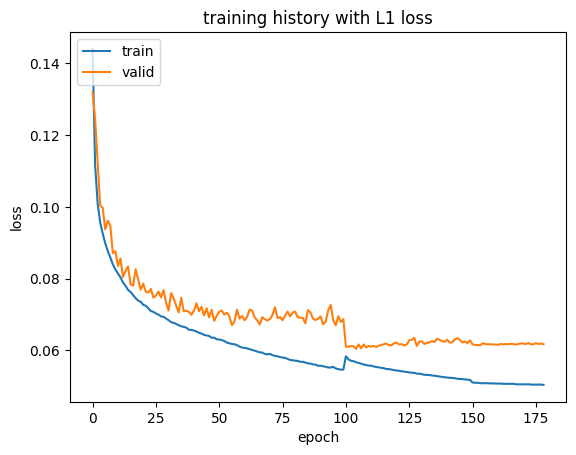

In [13]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history with L1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_L1loss.png')
plt.show()

We conclude training at epoch 164 with a training loss (accuracy) of 0.0507 (76.83%) and a validation set loss (accuracy) of 0.0618 (76.28%).  

In [14]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/Training_m3_L1loss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Reconstructions based on the above**

In [16]:
def plot_reconstruction(set, name,seed_val, epochs, scale, model_name):

  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(np.ceil(9*scale),np.ceil(4*scale)))
  recon.suptitle(model_name + ' with latent_dim = ' + str(latent_dim) +': reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

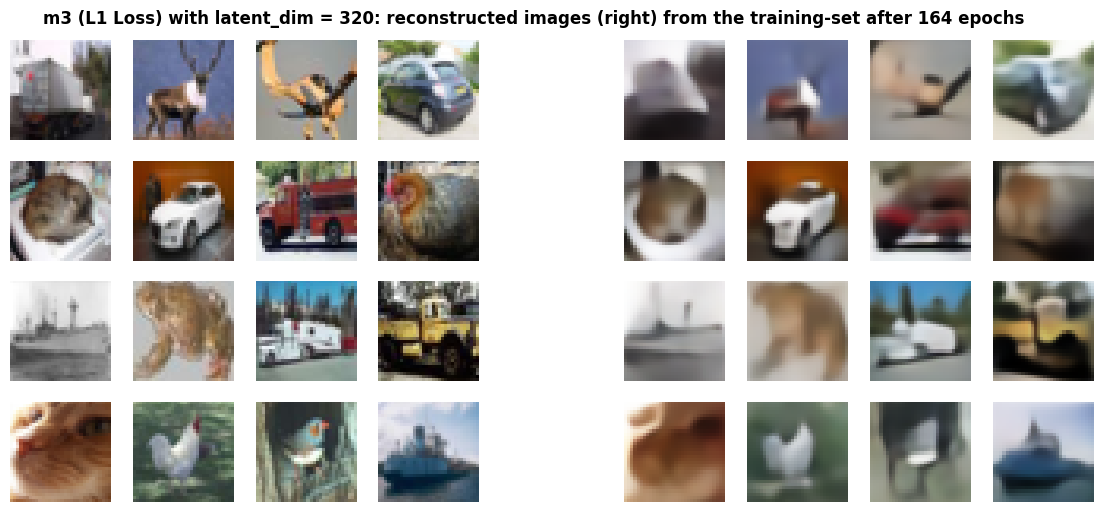

In [17]:
plot_reconstruction(img_train, 'training', 123, 164, 1.5, 'm3 (L1 Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_TrainSet_1.png')

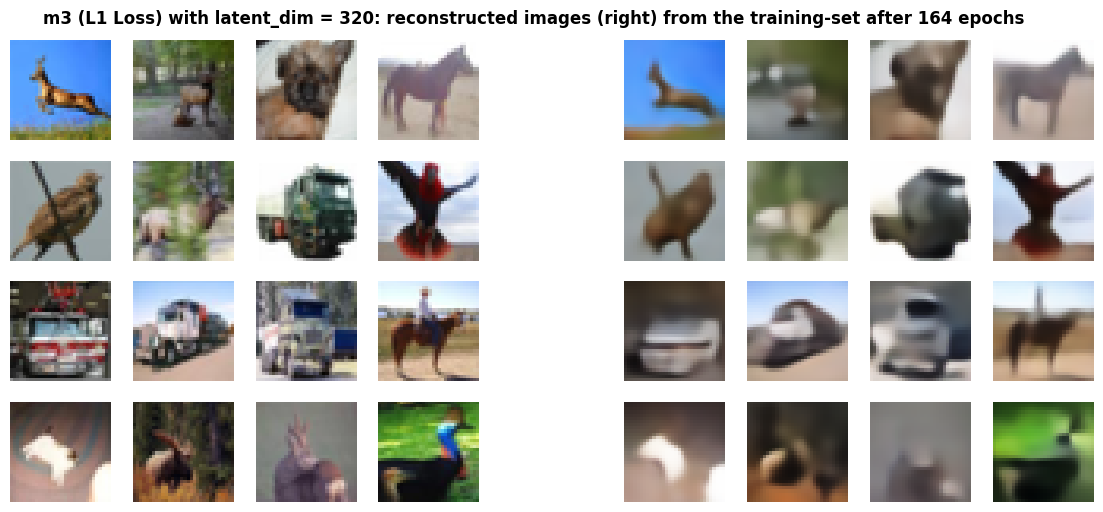

In [20]:
plot_reconstruction(img_train, 'training', 1000, 164, 1.5, 'm3 (L1 Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_TrainSet_2.png')

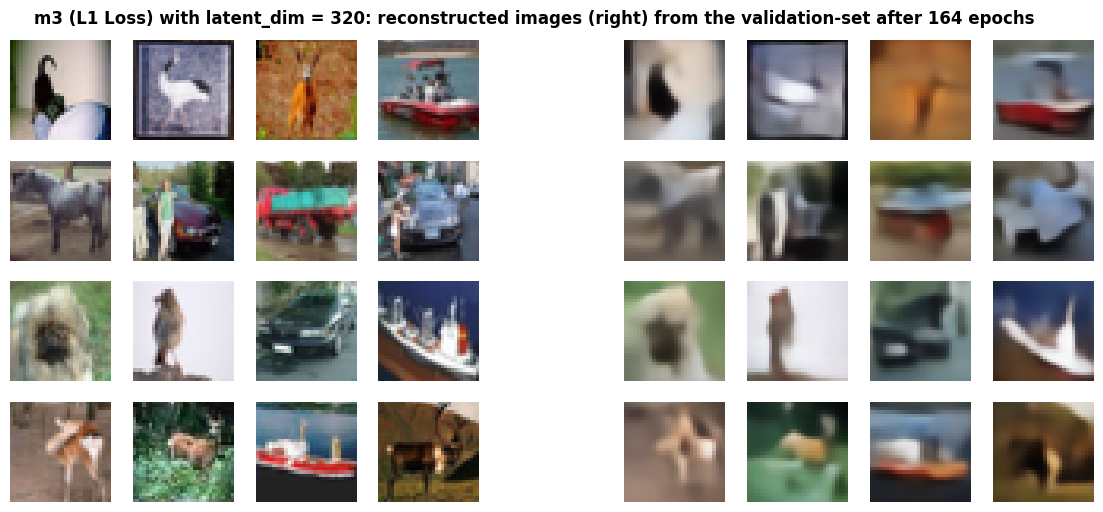

In [21]:
plot_reconstruction(img_valid, 'validation', 123, 164, 1.5, 'm3 (L1 Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_ValidSet_1.png')

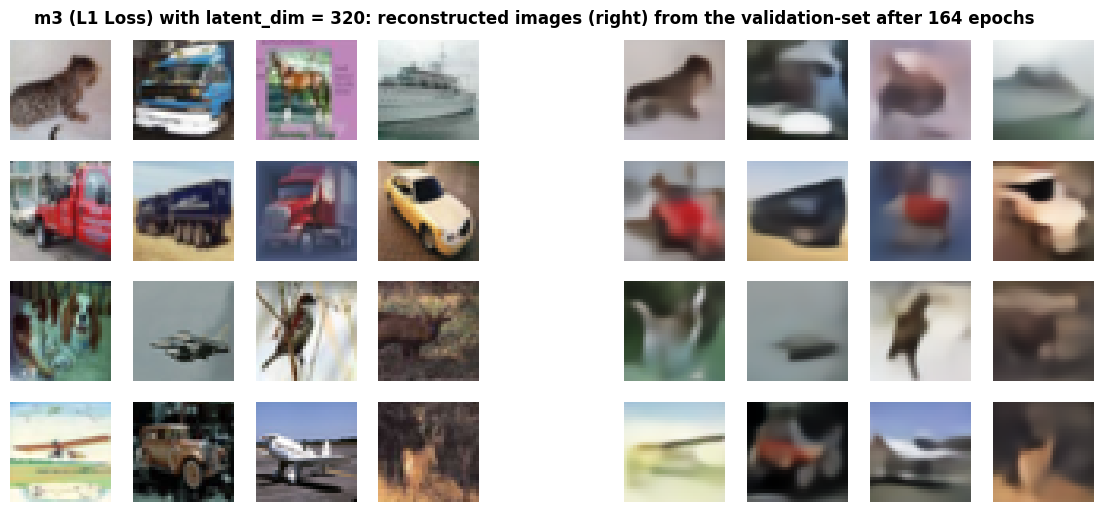

In [22]:
plot_reconstruction(img_valid, 'validation', 1000, 164, 1.5, 'm3 (L1 Loss)')

plt.savefig('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_ValidSet_2.png')

In [23]:
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_TrainSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_TrainSet_2.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_ValidSet_1.png')
files.download('/content/AE-w.-Bottleneck-Residual-Blocks/plots_figures/m3_L1loss_reconstructions_ValidSet_2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Conclusions**

Accuracy numbers obtained are slightly better than the ones obtained with L2 or with CB loss, qualitatively the reconstructions look similar to the ones using L2.